In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Load dataset
df = pd.read_csv('Data/arxiv_dataset.csv')

In [6]:
df.head()

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,year,text,processed_text
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,1993-08-01,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79,1993,Dynamic Backtracking Because of their occasion...,"[dynam, backtrack, occasion, need, return, sha..."
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,1993-08-01,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119,1993,A Market-Oriented Programming Environment and ...,"[market, orient, program, environ, applic, dis..."
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,1993-09-01,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167,1993,An Empirical Analysis of Search in GSAT We des...,"[empir, analysi, search, gsat, extens, studi, ..."
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,1993-11-01,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174,1993,The Difficulties of Learning Logic Programs wi...,"[difficulti, learn, logic, program, cut, real,..."
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,1993-11-01,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187,1993,Software Agents: Completing Patterns and Const...,"[softwar, agent, complet, pattern, construct, ..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136238 entries, 0 to 136237
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  136238 non-null  object        
 1   title               136238 non-null  object        
 2   category            136238 non-null  object        
 3   category_code       136238 non-null  object        
 4   published_date      136238 non-null  datetime64[ns]
 5   updated_date        136238 non-null  object        
 6   authors             136238 non-null  object        
 7   first_author        136238 non-null  object        
 8   summary             136238 non-null  object        
 9   summary_word_count  136238 non-null  int64         
 10  year                136238 non-null  int32         
 11  text                136238 non-null  object        
 12  processed_text      136238 non-null  object        
dtypes: datetime64[ns](1), int32(1

In [9]:
print(len(df))

136238


In [10]:
print(df.isnull().sum())

id                    0
title                 0
category              0
category_code         0
published_date        0
updated_date          0
authors               0
first_author          0
summary               0
summary_word_count    0
year                  0
text                  0
processed_text        0
dtype: int64


In [12]:
print(df['category'].value_counts().head(20))

category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
Neural and Evolutionary Computing                          5509
Robotics                                                    903
Information Retrieval                                       901
Methodology (Statistics)                                    882
Computation and Language (Legacy category)                  750
Optimization and Control                                    749
Cryptography and Security                                   665
Computers and Society                                       515
Social and Information Networks                             417
Human-Computer Interaction                                  411
Signal Processing              

In [2]:
# Ensure date is in correct format
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.dropna(subset=['published_date'])
df['year'] = df['published_date'].dt.year

# Combine title and summary for topic modeling
df['text'] = df['title'] + ' ' + df['summary']

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11380\4151593767.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
from collections import defaultdict


In [18]:
# Konversi tanggal dan filter data
df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")
df = df.dropna(subset=["published_date", "title", "summary"])  # Drop missing data
df["year"] = df["published_date"].dt.year  # Ekstrak tahun dari published_date


In [22]:
#Preprocessing
def preprocess_string(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # hapus tanda baca/angka
    text = re.sub(r'\b\w{1,2}\b', '', text)  # hapus kata sangat pendek
    tokens = text.split()
    stopwords = set(["the","and","for","with","that","from","this","are","was","were","have","has","had"])  # contoh
    tokens = [t for t in tokens if t not in stopwords]
    return " ".join(tokens)

In [26]:
import re
df["titlesummary_text"] = df["title"].astype(str) + " " + df["summary"].astype(str)
df["titlesummary_text"] = df["titlesummary_text"].apply(preprocess_string)

In [28]:
num_topics = 5
topic_labels = []
years = sorted(df['year'].unique())
topic_trends = {}

for year in years:
    df_year = df[df['year'] == year]
    
    # Vectorization
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X_year = vectorizer.fit_transform(df_year['titlesummary_text'])
    words = np.array(vectorizer.get_feature_names_out())
    
    # LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    topic_distribution = lda.fit_transform(X_year)
    
    # Ambil kata dominan tiap topik (hanya sekali di tahun pertama)
    if len(topic_labels) == 0:
        for topic_idx, topic in enumerate(lda.components_):
            top_word = words[np.argsort(topic)[-1]]
            topic_labels.append(top_word)
    
    # Simpan rata-rata distribusi topik per tahun
    topic_trends[year] = np.mean(topic_distribution, axis=0)

# DataFrame tren topik
topic_trends_df = pd.DataFrame(topic_trends).T
topic_trends_df.columns = topic_labels
print(topic_trends_df)


        search   systems  information  problems  problems
1993  0.169639  0.170061     0.641786  0.009257  0.009257
1994  0.211036  0.170209     0.184457  0.226486  0.207813
1995  0.137429  0.306761     0.201184  0.152125  0.202501
1996  0.287186  0.116667     0.206154  0.194759  0.195235
1997  0.185381  0.217894     0.203006  0.273146  0.120574
1998  0.250667  0.260323     0.214347  0.166733  0.107930
1999  0.198308  0.222386     0.205621  0.259980  0.113705
2000  0.175195  0.204889     0.243042  0.204633  0.172240
2001  0.308829  0.157502     0.213021  0.224311  0.096336
2002  0.124461  0.204245     0.323679  0.249962  0.097653
2003  0.227885  0.201957     0.096115  0.190496  0.283547
2004  0.336772  0.110877     0.146372  0.232194  0.173785
2005  0.221712  0.241785     0.149873  0.175204  0.211426
2006  0.154258  0.268499     0.243247  0.152949  0.181046
2007  0.145481  0.175088     0.192183  0.246310  0.240937
2008  0.207601  0.090375     0.277377  0.297099  0.127548
2009  0.179038

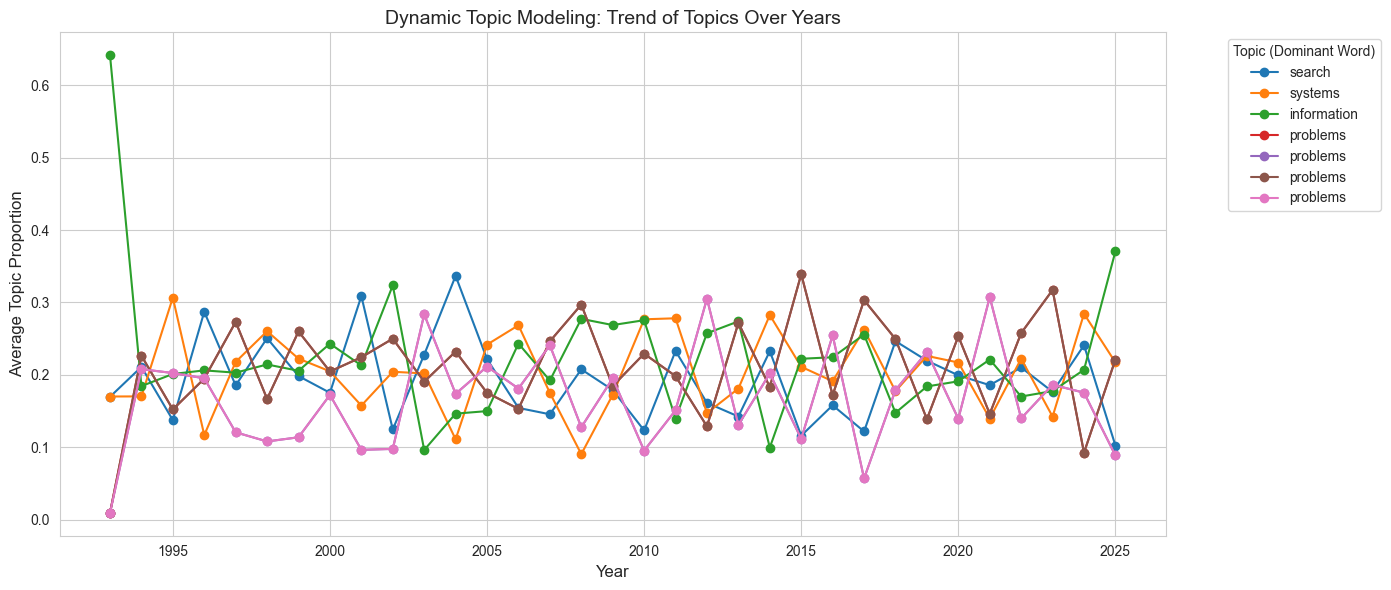

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.set_style("whitegrid")

for topic in topic_trends_df.columns:
    plt.plot(topic_trends_df.index, topic_trends_df[topic], marker='o', label=topic)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Topic Proportion", fontsize=12)
plt.title("Dynamic Topic Modeling: Trend of Topics Over Years", fontsize=14)
plt.legend(title="Topic (Dominant Word)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

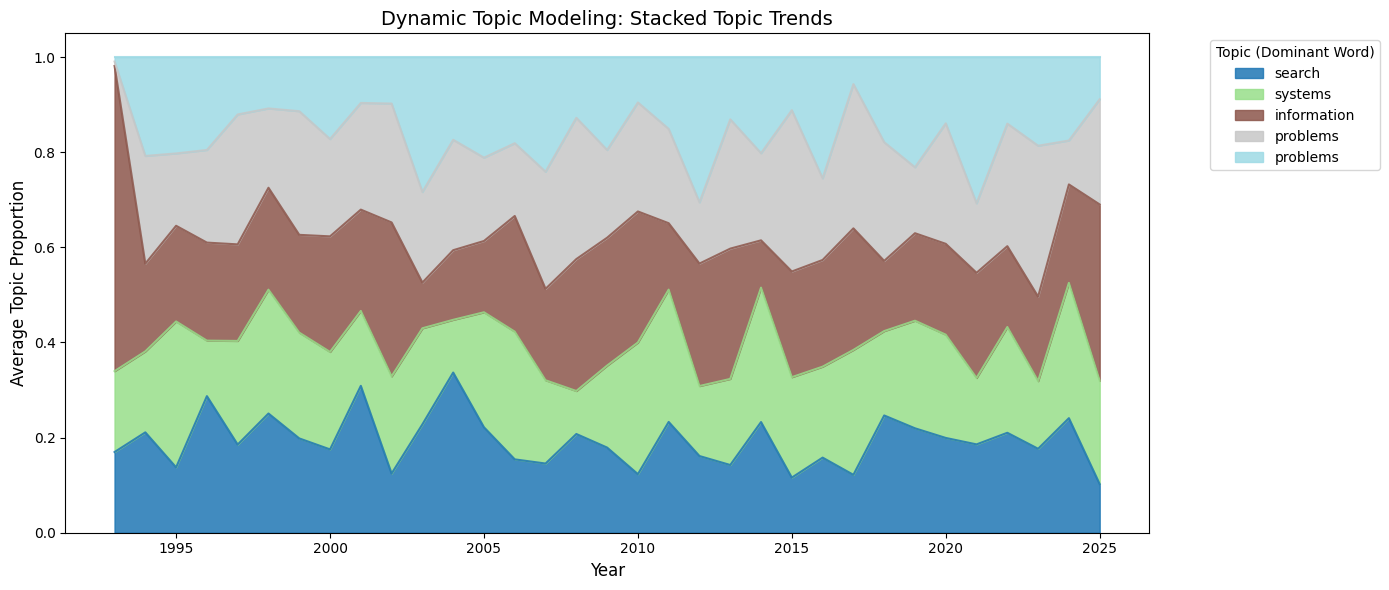

In [29]:
plt.figure(figsize=(14,6))
topic_trends_df.plot.area(figsize=(14,6), cmap='tab20', alpha=0.85)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Topic Proportion", fontsize=12)
plt.title("Dynamic Topic Modeling: Stacked Topic Trends", fontsize=14)
plt.legend(title="Topic (Dominant Word)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


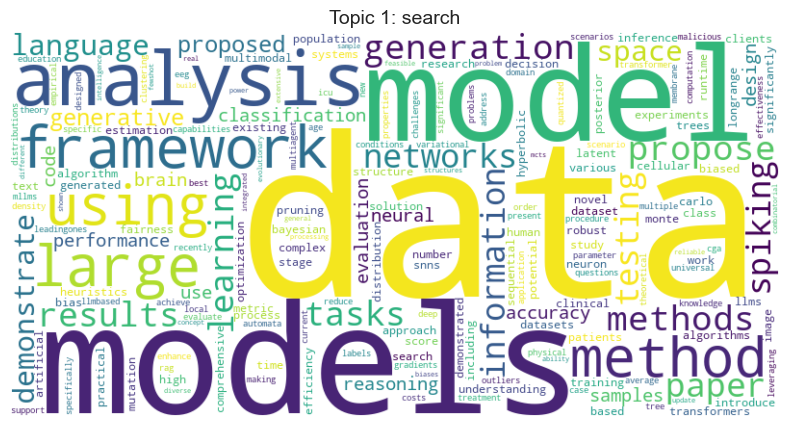

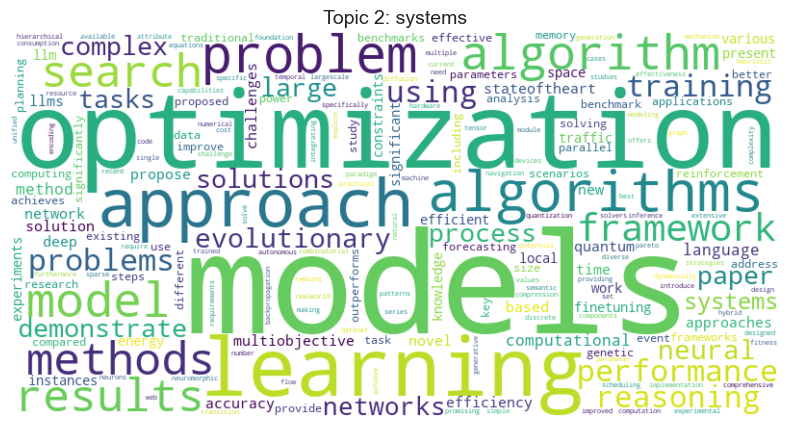

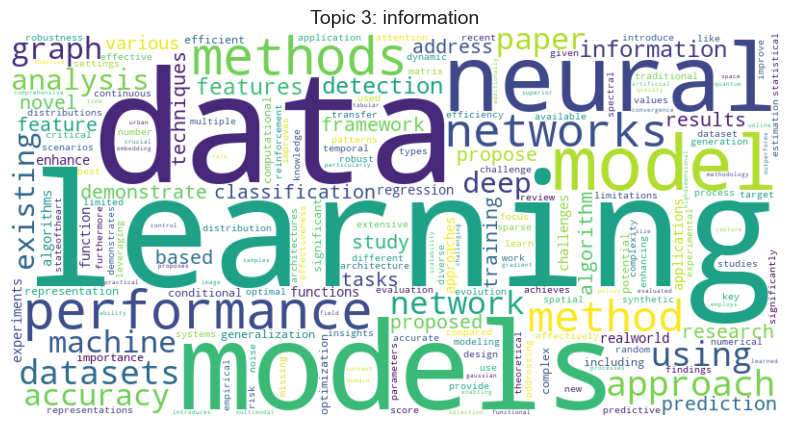

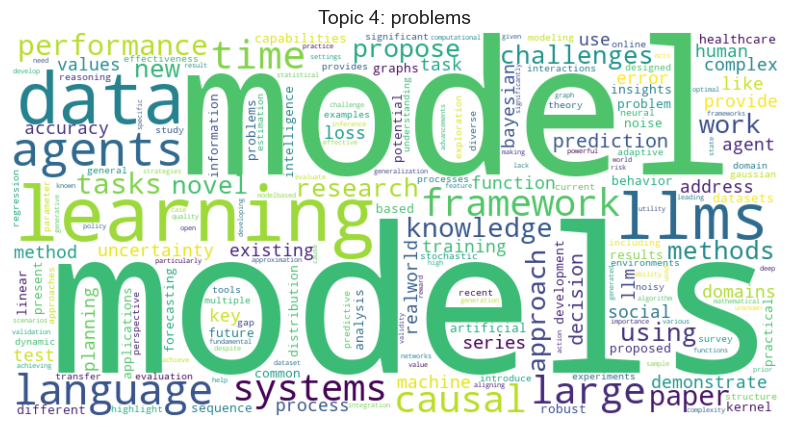

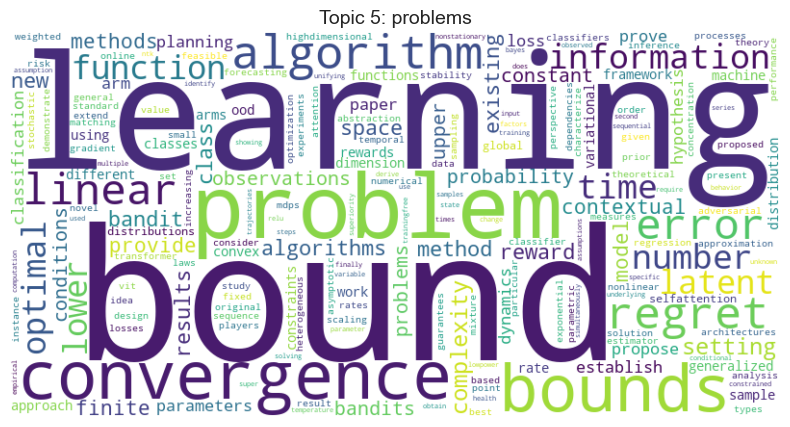

In [31]:
from wordcloud import WordCloud

# Misal ambil kata-kata dari tahun pertama sebagai representasi topik
for topic_idx, topic in enumerate(lda.components_):
    words_freq = {words[i]: topic[i] for i in range(len(words))}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx+1}: {topic_labels[topic_idx]}", fontsize=14)
    plt.show()
